### SETUP

In [ ]:
!pip install --user tfx tensorflow Pillow tensorflow_datasets matplotlib azure-storage-blob

### Imports


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import IPython.display as display
from azure.storage.blob import BlobServiceClient, AccountSasPermissions, ResourceTypes
from datetime import datetime, timedelta
import random
from io import BytesIO

### Downloading images from Azure

In [ ]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=datacentricthesis;AccountKey=Z2yIApz/GjhHPu28cAclxOnaqChRERQlrmGkfqfDcpCLlBRo/oPBN8n3Mhg6cRVFR5b/iS0ZxZ/D+ASt378Qfw==;EndpointSuffix=core.windows.net"
account_name = "datacentricthesis"

In [ ]:
def download_directory_from_blob_storage(blob_service_client, container_name, destination_directory, prefix=""):
  container_client = blob_service_client.get_container_client(container_name)
  blob_list = container_client.list_blobs(name_starts_with=prefix)
  
  for blob in blob_list:
    blob_path = os.path.relpath(blob.name, prefix)
    local_path = os.path.join(destination_directory, blob_path)

    os.makedirs(os.path.dirname(local_path), exist_ok=True)

    blob_client = container_client.get_blob_client(blob.name)
    with open(local_path, "wb") as file:
        file.write(blob_client.download_blob().readall())

In [ ]:
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "flowers"
destination_directory = "./azure_blob_storage_test"
prefix = "flower_photos/"

if not (os.path.exists(destination_directory)):
  print("Only create and download if destination doesn't extist so we don't override it \n")
  
  download_directory_from_blob_storage(blob_service_client, container_name, destination_directory, prefix)

In [82]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


### Manually splitting dataset into train and test directories

In [ ]:
import os
import shutil
import random

def split_dataset_into_train_and_test(image_directory, output_directory, train_split=0.8):
    # List all the category subdirectories in the main directory
    categories = [d for d in os.listdir(image_directory) if os.path.isdir(os.path.join(image_directory, d))]

    # Create train and test directories in the output directory
    train_directory = os.path.join(output_directory, 'train')
    test_directory = os.path.join(output_directory, 'test')

    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    # Iterate through each category subdirectory
    for category in categories:
        category_directory = os.path.join(image_directory, category)

        # List all the image files in the category subdirectory
        images = os.listdir(category_directory)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))]

        # Shuffle the list of image files
        random.shuffle(images)

        # Create category subdirectories in train and test directories
        train_category_directory = os.path.join(train_directory, category)
        test_category_directory = os.path.join(test_directory, category)

        os.makedirs(train_category_directory, exist_ok=True)
        os.makedirs(test_category_directory, exist_ok=True)

        # Split the image files into train and test sets
        split_index = int(len(images) * train_split)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Copy the images to the respective directories
        for img in train_images:
            shutil.copy2(os.path.join(category_directory, img), os.path.join(train_category_directory, img))

        for img in test_images:
            shutil.copy2(os.path.join(category_directory, img), os.path.join(test_category_directory, img))

        print(f'Successfully split {len(images)} images in category "{category}" into {len(train_images)} train and {len(test_images)} test images.')

image_directory = 'azure_blob_storage_test'
data_root ='flowers'
os.makedirs(data_root, exist_ok=True)
split_dataset_into_train_and_test(image_directory, data_root)


### Darken images in train part of dataset



In [ ]:
!pip install cleanvison

Reading images from /workspaces/tfx_test_case/flowers/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 2934/2934 [00:04<00:00, 729.18it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |           20 |
|  1 | exact_duplicates |            4 |
|  2 | near_duplicates  |            4 |
|  3 | odd_aspect_ratio |            3 | 


Top 4 examples with blurry issue in the dataset.


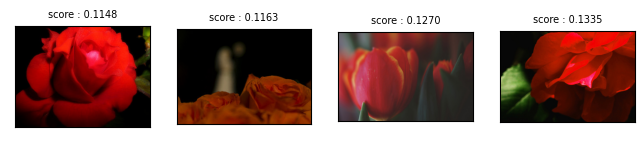

Found 2 sets of images with exact_duplicates issue in the dataset.
Set: 0


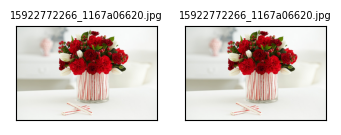

Set: 1


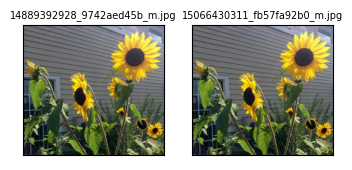

Found 2 sets of images with near_duplicates issue in the dataset.
Set: 0


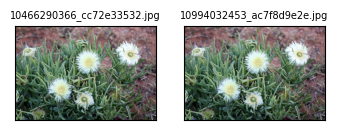

Set: 1


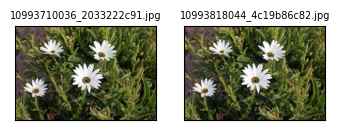

Found 3 examples with odd_aspect_ratio issue in the dataset.


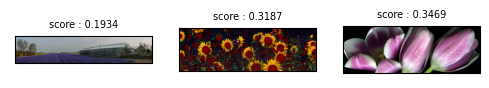

In [91]:
# Show how many issues with dataset
#Finding faults with train images.
from cleanvision.imagelab import Imagelab

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="flowers/train/")

issue_types = {"dark": {}}
#imagelab.find_issues(issue_types=issue_types)
imagelab.find_issues()

# Produce a report with only the specified issue_types
imagelab.report()



In [93]:
## Script to darken 25% of images

import os
import random
from PIL import Image, ImageEnhance
import glob

def process_images(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for root, dirs, files in os.walk(input_path):
        rel_path = os.path.relpath(root, input_path)
        output_subdir = os.path.join(output_path, rel_path)
        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)

        images = glob.glob(os.path.join(root, "*.jpg")) + glob.glob(os.path.join(root, "*.png"))

        num_to_darken = len(images) // 4
        random.seed(10)
        images_to_darken = random.sample(images, num_to_darken)

        for image_path in images:
            image = Image.open(image_path)
            image_filename = os.path.basename(image_path)
            output_image_path = os.path.join(output_subdir, image_filename)

            if image_path in images_to_darken:
                enhancer = ImageEnhance.Brightness(image)
                darker_image = enhancer.enhance(0.3)
                darker_image.save(output_image_path)
            else:
                image.save(output_image_path)



input_directory = "flowers/train"
output_directory = "darkened_images"
process_images(input_directory, output_directory)
print("Processing completed. Darkened images have been saved to the 'darkened_images' directory.")

Processing completed. Darkened images have been saved to the 'darkened_images' directory.


Reading images from /workspaces/tfx_test_case/darkened_images
Checking for dark images ...


100%|██████████| 2934/2934 [00:10<00:00, 271.15it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type   |   num_images |
|---:|:-------------|-------------:|
|  0 | dark         |          731 | 


Top 4 examples with dark issue in the dataset.


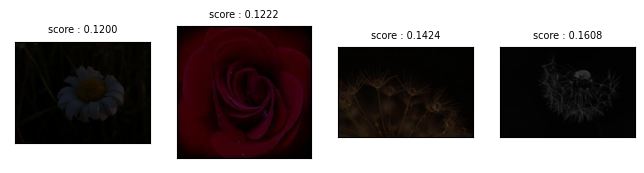

In [94]:
# Show how many issues with dataset
#Finding faults with train images.

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="darkened_images/")

issue_types = {"dark": {}}
imagelab.find_issues(issue_types=issue_types)

# Produce a report with only the specified issue_types
imagelab.report()


In [ ]:
_dataset_modifier_file = 'scripts/remove_dark_images.py'

In [ ]:
%%writefile {_dataset_modifier_file}

#Takes a list of image paths and removes them
import os

from cleanvision.imagelab import Imagelab

def count_files(directory_path):
    file_count = 0

    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)

    print(f"The total number of files in '{directory_path}' and its subdirectories is: {file_count}")



def remove_images(image_paths):
    for image_path in image_paths:
        if os.path.isfile(image_path):
            try:
                os.remove(image_path)
            except OSError as e:
                print(f"Error removing {image_path}: {e}")
        else:
            print(f"{image_path} is not a valid file path.")




# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path="darkened_images/")

issue_types = {"dark": {}}

imagelab.find_issues(issue_types=issue_types)


dark_images = imagelab.issues[imagelab.issues["is_dark_issue"] == True].sort_values(by=['dark_score'])
dark_image_files = dark_images.index.tolist()

count_files('darkened_images')

remove_images(dark_image_files)

count_files('darkened_images')

In [ ]:
%run 'scripts/remove_dark_images.py'

In [ ]:
import os
import shutil

def move_and_rename_directory(directory_path, new_name=None):
    if os.path.isdir(directory_path):
        parent_dir = os.path.dirname(directory_path)
        new_dataset_dir = os.path.join(parent_dir, "flowers_incomplete_dataset")

        if not os.path.exists(new_dataset_dir):
            os.makedirs(new_dataset_dir)

        directory_name = new_name if new_name else os.path.basename(directory_path)
        target_directory = os.path.join(new_dataset_dir, directory_name)

        if not os.path.exists(target_directory):
            shutil.move(directory_path, target_directory)
            print(f"Moved {'and renamed' if new_name else ''} '{directory_path}' to '{target_directory}'")
        else:
            print(f"Error: '{target_directory}' already exists.")
    else:
        print(f"{directory_path} is not a valid directory path.")


move_and_rename_directory('darkened_images', 'train')
## move test dir into flowers_incomplete_dataset


## Setting up variables

In [67]:

schema_path= "flower-tfdv-schema"
PIPELINE_NAME = 'flower_pipeline'
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)


#data_root ='flowers'
data_root = 'flowers_incomplete_dataset'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'test')

IMG_HEIGHT = 180
IMG_WIDTH = 180

SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'flowers.db')


### Converting images to tf.record files

In [68]:
import os
import random
import tensorflow as tf
import PIL.Image
from io import BytesIO

flower_classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

os.makedirs('flowers-tfrecord/train', exist_ok=True)
os.makedirs('flowers-tfrecord/test', exist_ok=True)
train_tfrecord = 'flowers-tfrecord/train/train_data.tfrecords'
test_tfrecord = 'flowers-tfrecord/test/test_data.tfrecords'

label_map = {
    'daisy': 0,
    'dandelion': 1,
    'roses': 2,
    'sunflowers': 3,
    'tulips': 4
}

def serialize_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_TFRecord(image_path, label):
    image = PIL.Image.open(image_path)
    image = image.resize((IMG_HEIGHT, IMG_WIDTH))

    with BytesIO() as output:
        image.save(output, format='JPEG')
        image_bytes = output.getvalue()

    example = serialize_example(image_bytes, label)
    return example

with tf.io.TFRecordWriter(train_tfrecord) as writer:
    for flower_class in flower_classes:
        for file in os.listdir(os.path.join(train_dir, flower_class)):
            image_path = os.path.join(train_dir, flower_class, file)
            label = label_map[flower_class]
            writer.write(write_TFRecord(image_path, label))

with tf.io.TFRecordWriter(test_tfrecord) as writer:
    for flower_class in flower_classes:
        for file in os.listdir(os.path.join(test_dir, flower_class)):
            image_path = os.path.join(test_dir, flower_class, file)
            label = label_map[flower_class]
            writer.write(write_TFRecord(image_path, label))

print("Train and test TFRecord files created.")


Train and test TFRecord files created.


### Checking if decoding tfrecord file works

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def _parse_function(example_proto):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    return parsed_features

def display_first_matching_by_label(tfrecord_file, label_number):
    label_to_flower = {
        0: 'daisy',
        1: 'dandelion',
        2: 'roses',
        3: 'sunflowers',
        4: 'tulips'
    }
    
    raw_image_dataset = tf.data.TFRecordDataset(tfrecord_file)
    image_dataset = raw_image_dataset.map(_parse_function)

    for image_features in image_dataset:
        label = image_features['label']
        if label == label_number:
            encoded_image = image_features['image_raw'].numpy()
            decoded_image = tf.image.decode_jpeg(encoded_image, channels=3)
            plt.imshow(decoded_image)
            plt.title(f'Label: {label} {label_to_flower[label_number]}')
            plt.show()
            break

# Display the first image with the specified label (0 to 4) from the train TFRecord file
display_first_matching_by_label(train_tfrecord, 4)


### Model code

In [ ]:
_trainer_module_file = 'flower_trainer.py'

In [86]:
%%writefile {_trainer_module_file}

import tensorflow as tf
from tfx import v1 as tfx
import matplotlib.pyplot as plt
import tensorflow_transform as tft
from tfx_bsl.tfxio import dataset_options
import os
import gzip
from typing import List
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_transform.tf_metadata import schema_utils

_IMAGE_KEY = 'image_raw'
_LABEL_KEY = 'label'
IMG_HEIGHT = 180
IMG_WIDTH = 180
batch_size = 8

# TODO: Change this to what the actual train/test dir amount is, can be found with a print somewhere above
#_TRAIN_DATA_SIZE = 2934
_TRAIN_DATA_SIZE = 2203
_TEST_DATA_SIZE = 736


def _transformed_name(key):
  return key + '_xf'

# TFX Transform will call this function.
def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}
  print("Transformer preprocessing is running....")
  image_features = tf.map_fn(
      lambda x: tf.io.decode_jpeg(x[0], channels=3),
      inputs[_IMAGE_KEY],
      dtype=tf.uint8)
  
  #image_features = tf.cast(image_features, tf.float32)
  image_features = tf.image.resize(image_features, [IMG_HEIGHT, IMG_WIDTH])
  # Normalize the image features
  # image_features = image_features / 255.0

  image_features = tf.keras.applications.mobilenet.preprocess_input(
     image_features)

  outputs[_transformed_name(_IMAGE_KEY)] = image_features
  outputs[_transformed_name(_LABEL_KEY)] = inputs[_LABEL_KEY]
  
  return outputs


# Define a function to parse the tfrecord dataset
def _parse_function(features, label):
   image = features[_transformed_name(_IMAGE_KEY)]
   return image, label

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 12) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """  
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_transformed_name(_LABEL_KEY)),
      tf_transform_output.transformed_metadata.schema)
  
  return dataset

# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
    
    print("\n\n\n Trainer component is running ... \n\n\n")

    epochs = 2
    # attempt at making a different model architecture that should be smaller than the original
    
    
    model = tf.keras.Sequential([
      #tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid'),
      tf.keras.layers.Dense(5)
    ])
    
    
 
    # Compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
 
    # Print a summary of the model
    model.summary()

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
 
    train_ds = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)
    
    train_ds = train_ds.map(_parse_function)

    eval_ds = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)
    
    eval_ds = eval_ds.map(_parse_function)

    steps_per_epoch = int(_TRAIN_DATA_SIZE / batch_size)
    validation_steps = int(_TEST_DATA_SIZE / batch_size)

    # Train our model
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=eval_ds, 
                        steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # The result of the training should be saved in `fn_args.serving_model_dir`
    # directory.
    model.save(fn_args.serving_model_dir, save_format='tf')

Overwriting flower_trainer.py


### Pipeline definition

In [87]:

### This pipeline hard codes the dataset path inside the pipeline instead of as a input when running orchestrator
from tfx.proto import example_gen_pb2
from tfx.components import ImportExampleGen
from tfx import v1 as tfx
def _create_pipeline(pipeline_name: str, pipeline_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])
#TODO: Move hardcoded input base into an external variable and send it into the pipeline
  # Brings data into the pipeline.
  example_gen = ImportExampleGen(
      input_base='flowers-tfrecord', input_config=input_config)

  # Computes statistics over data for visualization and schema generation.
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])
  
  # Generates schema based on the generated statistics.
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)

  #Performs anomaly detection based on statistics and data schema.
  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema = schema_gen.outputs['schema']
  )

  # Performs transformations and feature engineering in training and serving.
  transform = tfx.components.Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      module_file=module_file)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema= schema_gen.outputs['schema'],
      )
  
  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))
  
  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      transform,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

### Run Pipeline

Pipeline creation is running...



running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying penguin_utils.py -> build/lib
copying dogs_vs_cats_trainer.py -> build/lib
copying flower_trainer.py -> build/lib
copying remove_csv.py -> build/lib


/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


installing to /tmp/tmp655rcbrv
running install
running install_lib
copying build/lib/penguin_utils.py -> /tmp/tmp655rcbrv
copying build/lib/dogs_vs_cats_trainer.py -> /tmp/tmp655rcbrv
copying build/lib/flower_trainer.py -> /tmp/tmp655rcbrv
copying build/lib/remove_csv.py -> /tmp/tmp655rcbrv
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmp655rcbrv/tfx_user_code_Transform-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3.7.egg-info
running install_scripts
creating /tmp/tmp6

/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


copying build/lib/penguin_utils.py -> /tmp/tmpunctxu2t
copying build/lib/dogs_vs_cats_trainer.py -> /tmp/tmpunctxu2t
copying build/lib/flower_trainer.py -> /tmp/tmpunctxu2t
copying build/lib/remove_csv.py -> /tmp/tmpunctxu2t
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpunctxu2t/tfx_user_code_Trainer-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3.7.egg-info
running install_scripts
creating /tmp/tmpunctxu2t/tfx_user_code_Trainer-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f3

Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3-none-any.whl


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Transform-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3-none-any.whl
Transformer preprocessing is running....


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....


Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
Transformer preprocessing is running....
INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/48/.temp_path/tftransform_tmp/15b2da58785041ed93ea4ef743c1ce4f/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Transform/transform_graph/48/.temp_path/tftransform_tmp/15b2da58785041ed93ea4ef743c1ce4f/assets


Transformer preprocessing is running....
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Processing ./pipelines/flower_pipeline/_wheels/tfx_user_code_Trainer-0.0+ef29c20fd6eef5eb2fc98b1193e7f28f8085c8016ce43c057f32779129dacb54-py3-none-any.whl



 Trainer component is running ... 





You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 41, 41, 32)       

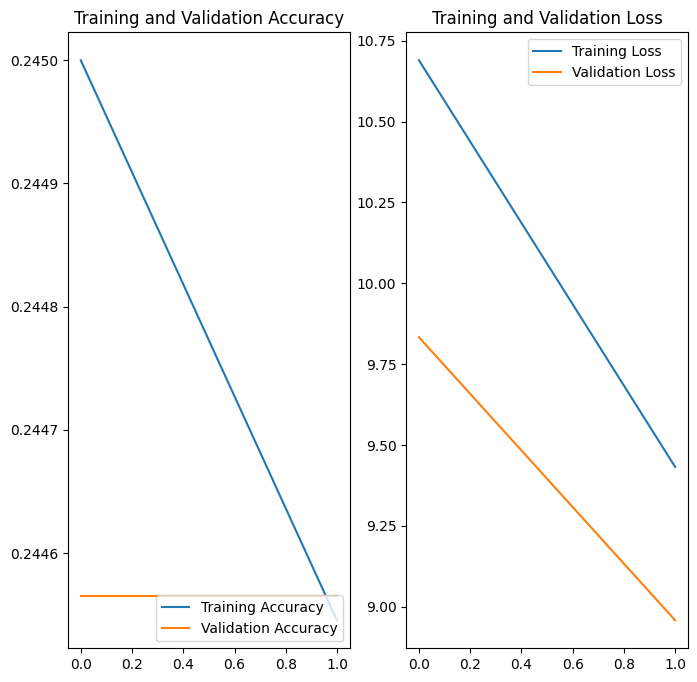

INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/49/Format-Serving/assets


INFO:tensorflow:Assets written to: pipelines/flower_pipeline/Trainer/model/49/Format-Serving/assets


In [88]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

### Model accuracy test

### Result querying

In [ ]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}

In [ ]:
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.

def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e:e.last_update_time_since_epoch)
  return execution_lib.get_output_artifacts(metadata, latest_execution.id)

# Non-public APIs, just for showcase.
from tfx.orchestration.experimental.interactive import visualizations

def visualize_artifacts(artifacts):
  """Visualizes artifacts using standard visualization modules."""
  for artifact in artifacts:
    visualization = visualizations.get_registry().get_visualization(
        artifact.type_name)
    if visualization:
      visualization.display(artifact)

from tfx.orchestration.experimental.interactive import standard_visualizations
standard_visualizations.register_standard_visualizations()

In [ ]:
# Non-public APIs, just for showcase.
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  # Find output artifacts from MLMD.
  stat_gen_output = get_latest_artifacts(metadata_handler, PIPELINE_NAME,
                                         'StatisticsGen')
  stats_artifacts = stat_gen_output[standard_component_specs.STATISTICS_KEY]

  schema_gen_output = get_latest_artifacts(metadata_handler,
                                           PIPELINE_NAME, 'SchemaGen')
  schema_artifacts = schema_gen_output[standard_component_specs.SCHEMA_KEY]

In [ ]:
visualize_artifacts(stats_artifacts)

In [ ]:
visualize_artifacts(schema_artifacts)

In [ ]:
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  ev_output = get_latest_artifacts(metadata_handler, PIPELINE_NAME,
                                   'ExampleValidator')
  anomalies_artifacts = ev_output[standard_component_specs.ANOMALIES_KEY]

In [ ]:

visualize_artifacts(anomalies_artifacts)